# Example: Buffer Stock model solved via VFI in C.

Simple version of the buffer-stock model:
\begin{align}
V_{t}(M_{t},P_{t}) & =  \max_{C_{t}}\frac{C_{t}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[V_{t+1}(M_{t+1},P_{t+1})\right]\\
 & \text{s.t.}\\
A_{t} & =  M_{t}-C_{t}\quad\quad\:\:\text{{\color{darkgray}(assets)}}\\
M_{t+1} & =  RA_{t}+Y_{t+1}\quad\text{{\color{darkgray}(resources/cash-on-hand)}}\\
Y_{t+1} & =  P_{t+1}\xi_{t+1}\quad\quad\:{\color{darkgray}\text{(income)}}\\
P_{t+1} & =  GP_{t}\psi_{t+1}\quad\quad\:\:{\color{darkgray}\text{(perm. income)}}\\
A_{t} & \geq  0,\forall t\quad\quad\quad\quad{\color{darkgray}\text{(no borrowing)}}
\end{align}
where $\mathbb{E}_{{\color{red}t}}\left[V_{t+1}(M_{t+1},P_{t+1})\right]=\mathbb{E}\left[V_{t+1}(M_{t+1},P_{t+1}){\color{red}|}M_{{\color{red}t}},P_{{\color{red}t}},C_{{\color{red}t}}\right]$
are expectations over permanent and transitory income shocks,
$$
\log\xi_{t+1}\sim\mathcal{N}(\mu_{\xi},\sigma_{\xi}^{2}),\;\log\psi_{t+1}\sim\mathcal{N}(\mu_{\psi},\sigma_{\psi}^{2})
$$

**Terminal period, $T$:** Everything is consumed, 
\begin{align*}
C_{T}^{\star}(M_{T},P_{T}) & =M_{T}\\
V_{T}(M_{T},P_{T}) & =\frac{M_{T}^{1-\rho}}{1-\rho}.
\end{align*}

**Normalization:** The model is solved in normalized form, for $t<T$:

\begin{align}
v_{t}(m_{t}) & =  \max_{c_{t}}\frac{c_{t}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[(G\psi_{t+1})^{1-\rho}v_{t+1}(m_{t+1})\right]\\
 & \text{s.t.}\\
a_{t} & =  m_{t}-c_{t}\\
m_{t+1} & =  \frac{1}{G\psi_{t+1}}Ra_{t}+\xi_{t+1}\\
a_{t} & \geq  0.
\end{align}
with terminal period value function
$$
v_{T}(m_{T}) = V_{T}(M_{T},P_T)/P_T^{1-\rho}=\frac{m_{T}^{1-\rho}}{1-\rho}.
$$

**Numerical solution:**
- We use 100 points in the grid over resources, $m$.
- We use OpenMP to parallelize over the grid points, using `par.num_threads` threads.
- We use NLopt's `BOBYQA` algorithm to solve the maximization problem for each value of resources in the $m$-grid.
- We use 5 Gauss Hermite quadrature points in each of the income shocks to evaluate the two-dimensional integral in the expected value (25 points in total).
- We use linear interpolation to evaluate the next-period value function at each of these income shocks and guesses for consumption.

## Load packages

In [88]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup model instance and compile

In [89]:
from Example import ModelClass
model = ModelClass() 

# compile
do_compile = True # if True, then c++ files are compiled.
model.link_to_cpp(force_compile=do_compile)

# refer to model objects
par = model.par
sol = model.sol
sim = model.sim

## Solve model and illustrate consumption function

CPU times: total: 172 ms
Wall time: 156 ms


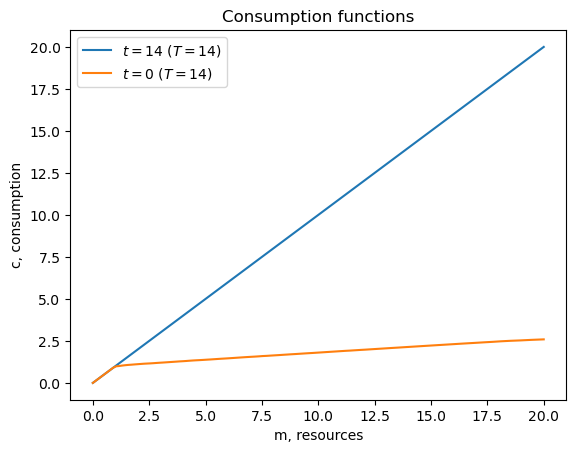

In [90]:
%time model.solve()

fig,ax = plt.subplots()
for t in (par.T-1,0):
    ax.plot(par.grid_m,sol.c[t],label=f'$t={t}$ ($T={par.T-1}$)')
ax.set(xlabel='m, resources',ylabel='c, consumption',title='Consumption functions')
ax.legend();

## Simulate model and plot consumption and wealth age profiles

CPU times: total: 0 ns
Wall time: 1 ms


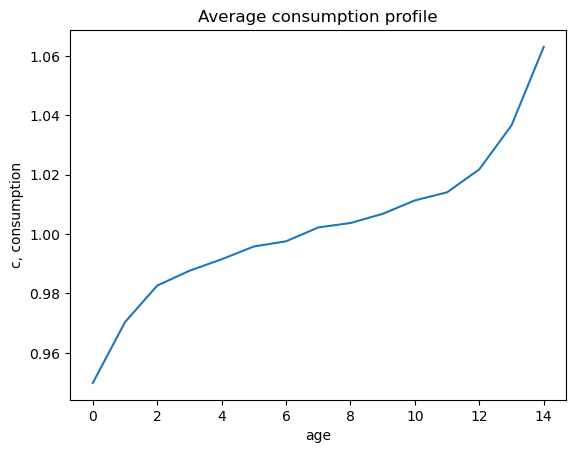

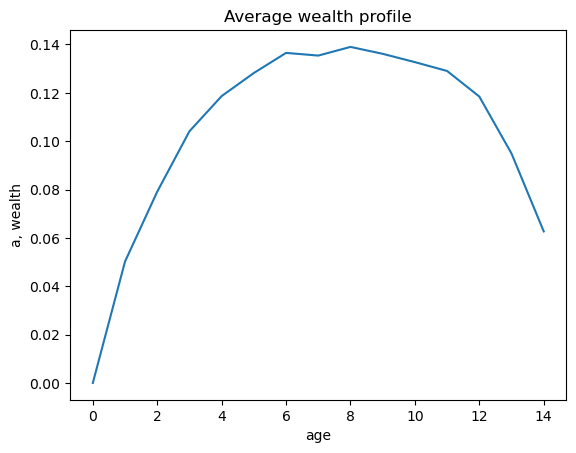

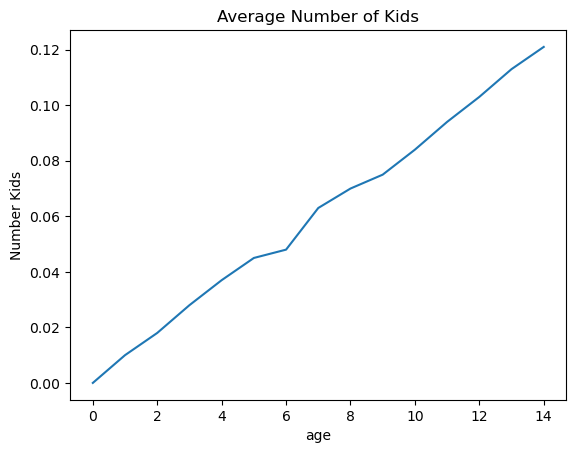

In [91]:
%time model.simulate()

fig,ax = plt.subplots()
ax.plot(np.mean(sim.c,axis=0))
ax.set(xlabel='age',ylabel='c, consumption',title='Average consumption profile');

fig,ax = plt.subplots()
ax.plot(np.mean(sim.a,axis=0))
ax.set(xlabel='age',ylabel='a, wealth',title='Average wealth profile');

fig,ax = plt.subplots()
ax.plot(np.mean(sim.Kids,axis=0))
ax.set(xlabel='age',ylabel='Number Kids',title='Average Number of Kids');

## Modification Challenge
Now, see if you can add random arrival of children. We will denote $n_t\in\{0,1\}$ as the number of children in the household. We restrict the number of children to one for simplicity and assume that the likelihood of a child arriving in period $t+1$ is
$$
\begin{align}
p(n_t)=&\begin{cases}
\begin{array}{ll}
p_n & \text{if } n_{t}=0\\
0 &  \text{if } n_{t}=1.
\end{array}\end{cases}
\end{align}
$$

and the recursive  formulation now is (normalized)

\begin{align}
v_{t}(m_{t},n_t) & =  \max_{c_{t}}\frac{(c_{t}/\nu(n_t))^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[(G\psi_{t+1})^{1-\rho}v_{t+1}(m_{t+1},n_{t+1})\right]\\
 & \text{s.t.}\\
a_{t} & =  m_{t}-c_{t}\\
m_{t+1} & =  \frac{1}{G\psi_{t+1}}Ra_{t}+\xi_{t+1}\\
n_{t+1}= &\begin{cases}
\begin{array}{ll}
n_{t}+1 & \text{with probability } p(n_{t})\\
n_{t} & \text{with probability } 1-p(n_{t})
\end{array}\end{cases} \\
a_{t} & \geq  0.
\end{align}
with terminal period value function
$$
v_{T}(m_{T},n_T) =\frac{(m_{T}/\nu(n_T))^{1-\rho}}{1-\rho}
$$
and equivalence scale 
$$
\nu(n_t)=1.0 + 0.3\cdot n_t.
$$
**Numerical solution:** Use the same setup as above but
- Add the new state variable, $n_t$, as a loop in the solution algorithm
- Add this dimension to the sol-structs in the setup-function
- Add the expectation wrt. child arrival when calculating the expected continuation value
- Add the equivalence scale in the utility function
- Add the new state variable in the simulations
- Simulate the new model by initializing everyone as childless. 